#**Deep Learning Homework 3: Convolutional Neural Networks**
### MSc Computer Science, Data Science, Cybersecurity @UNIPD
### 2nd semester - 6 ECTS
### Prof. Alessandro Sperduti, Prof. Nicolò Navarin and Dr. Luca Pasa
---
In this homework, we will explore how to develop a simple Convolutional Neural Network for image classification. We will use the CIFAR-10 dataset. In the first part, we will learn how to develop a simple CNN, while in the second part we will explore the impact of various hyper-parameters on the learning performances.

# Requirements
Let's start importing the libraries we will need and setting a couple of environmental variables.

**Disclaimer**: the notebook has been tested in Colab with Python `3.9.16`. Some parts *may* not work as expected using different packages and Python versions.

In [ ]:
print("You are using:")
!python --version


You are using:
Python 3.9.16


In [ ]:
# They've just released torch 2.0, but we will use the more stable torch=1.13 along with other supporting libriaries
!pip3 install pandas~=1.5 torch~=1.13 torchinfo torchdata~=0.5 torchtext~=0.14 torchvision~=0.14 torchaudio~=0.13

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 93.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 74.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 104.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 91.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 114.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 68.6 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling

In [ ]:
import torch
from torch import nn
from torch.nn import Conv2d, MaxPool2d, Linear
from torchinfo import summary
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Lambda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore") #Conflict of nn.functional.act_f and torch.act_f

print(f"{torch.__version__=}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device=}")
!nvidia-smi --format=csv --query-gpu=index,name,driver_version,memory.total,memory.used,memory.free

# Set seed for reproducibility
torch.manual_seed(43)
rng = np.random.default_rng(seed=4242)

torch.__version__='1.13.1+cu117'
device=device(type='cuda')
index, name, driver_version, memory.total [MiB], memory.used [MiB], memory.free [MiB]
0, Tesla T4, 525.85.12, 15360 MiB, 3 MiB, 15098 MiB


# Exercise 3.1: Simple CNN

## Data Loading and Preprocessing [TO COMPLETE]


We will use the `CIFAR-10` dataset.The dataset consists of $60.000$ images in $10$ classes, with $6.000$ images per class. There are $50.000$ training images and $10.000$ test images. Each sample is a $32\times32$ pixels color image (thus with an extra $\times3$ dimensions for the colors channels), associated with a label from one of the classes:

```python
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
```

We will divide the dataset in training, testing and validation set. As you already know, the training set will be used to train the model, the validation set will be used to perform model selection and finally, the test set will be used to asses the performance of deep network.

**[TO COMPLETE]**

In the standard dataset, each pixel intensity is represented by a `uint8` (byte) from $0$ to $255$. As a preprocessing step, we will rescale these values in the range $[0,1]$. You should write a simple so-called MinMaxScaler which takes as input a PIL Image (a specific format for images in Python) and rescales it, after making the appropriate type and shape transformations.

`%STARTCODE`

In [ ]:
def MinMaxScaler(img):#[TO COMPLETE]
  # First, we load the data as numpy array
  img_as_array = np.asarray(img)
  # TO COMPLETE: Transform the array to Tensor for PyTorch
  img_tensor = torch.from_numpy(img_as_array)
  # TO COMPLETE: image is of size (Height, Width, Channels). But torch excepts (C, H, W). Hence, the second thing is to permute.
  img_tensor_permuted = torch.permute(img_tensor, (2,0,1))
  # TO COMPLETE: Rescale image pixels form [0,255] to [0,1]
  img_min = torch.min(img_tensor_permuted)
  img_max = torch.max(img_tensor_permuted)
  normalized_img = (img_tensor_permuted - img_min) / (img_max - img_min)
  return normalized_img


'''
NEW DATA LOADING
Note that the previous function must be passed to transforms.Lambda().
'''
dataset = CIFAR10(root='data/', download=True, train=True, transform=transforms.Lambda(MinMaxScaler)) # 50000 samples
test_data = CIFAR10(root='data/', download=True, train=False, transform=transforms.Lambda(MinMaxScaler)) # 10000 samples

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


`%ENDCODE`

In [ ]:
# Let's check the classes and dataset shapes:
classes = dataset.classes
print(f"{classes=}")
print(f"Dataset shape: {dataset.data.shape}")
print(f"Test set shape: {test_data.data.shape}")

classes=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Dataset shape: (50000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)


In [ ]:
dataset

In [ ]:
# Let's also check whether the dataset is balanced, i.e. there are the same amount of samples for each class
label_count = {}
for _, idx in dataset:
    label = classes[idx]
    if label not in label_count:
        label_count[label] = 0
    label_count[label] += 1
label_count

{'frog': 5000,
 'truck': 5000,
 'deer': 5000,
 'automobile': 5000,
 'bird': 5000,
 'horse': 5000,
 'ship': 5000,
 'cat': 5000,
 'dog': 5000,
 'airplane': 5000}

We split the dataset into training/validation sets:

In [ ]:
val_size = 5000
train_size = len(dataset) - val_size

train_data, val_data = random_split(dataset, [train_size, val_size])
print(f"Training samples = {len(train_data)} \nValidation samples = {len(val_data)} \nTest samples = {len(test_data)}")

Training samples = 45000 
Validation samples = 5000 
Test samples = 10000


Let's see how normalized sample looks like...

In [ ]:
idx = 50 # 51st data sample
print(train_data[idx]) # (image, label) tensors
assert train_data[idx][0].max().item() <= 1., "Check your MinMaxScaler!"

(tensor([[[0.7059, 0.6878, 0.6923,  ..., 0.7692, 0.7692, 0.7647],
         [0.6878, 0.6697, 0.6787,  ..., 0.7511, 0.7466, 0.7466],
         [0.7059, 0.6923, 0.6878,  ..., 0.7285, 0.7240, 0.7195],
         ...,
         [0.7330, 0.7330, 0.7376,  ..., 0.7376, 0.7511, 0.7421],
         [0.7828, 0.7783, 0.7828,  ..., 0.7964, 0.7964, 0.7783],
         [0.8054, 0.7964, 0.7964,  ..., 0.7692, 0.7783, 0.7557]],

        [[0.6516, 0.6380, 0.6425,  ..., 0.7195, 0.7195, 0.7149],
         [0.6380, 0.6199, 0.6290,  ..., 0.7014, 0.6968, 0.6968],
         [0.6561, 0.6425, 0.6380,  ..., 0.6787, 0.6742, 0.6697],
         ...,
         [0.6787, 0.6742, 0.6787,  ..., 0.6787, 0.6923, 0.6833],
         [0.7285, 0.7285, 0.7330,  ..., 0.7466, 0.7466, 0.7285],
         [0.7557, 0.7466, 0.7466,  ..., 0.7195, 0.7285, 0.7059]],

        [[0.6335, 0.6199, 0.6244,  ..., 0.7014, 0.7014, 0.6968],
         [0.6154, 0.6018, 0.6109,  ..., 0.6833, 0.6787, 0.6787],
         [0.6380, 0.6244, 0.6199,  ..., 0.6606, 0.6561, 0

... it's better to see it as images!

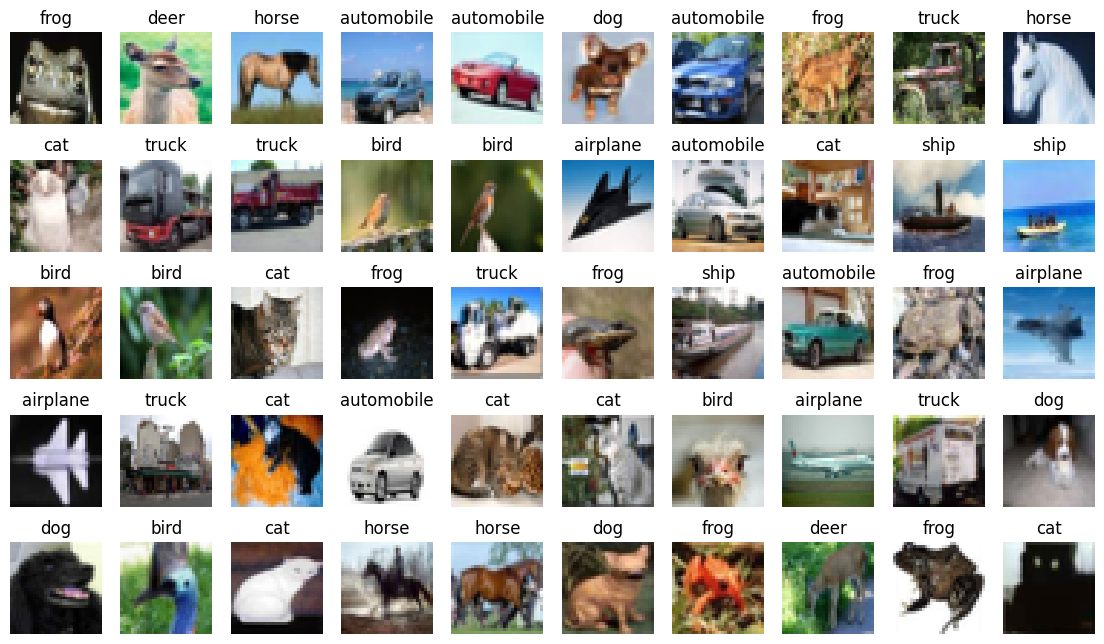

In [ ]:
img_chan, img_height, img_width = train_data[idx][0].shape #Channel, Height, Width

# Plots
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols*1.4, n_rows * 1.6))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        image, label = train_data[index]
        image = image.permute((1, 2, 0)) #C,H,W -> H,W,C
        plt.imshow(image, cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(classes[label])
plt.show()

Explain in the cell below when using Gradient Descent, why it is usually a good idea to ensure that all the features have a similar scale. 

`%STARTEXT`

Answer: By scaling our features, we smooth the flow of the gradient and make the algorithm to reach the minimum of cost function faster. In addition, we prevent the algorithm to get biased towards the features with higher values in magnitude since all values are scaled between 0 and 1.

`%ENDTEXT`

Since `train_data`, `val_data` and `test_data` are already PyTorch Datasets, we can use directly DataLoaders to load data from them.

In [ ]:
batch_size = 256
dataloader_training = DataLoader(train_data, batch_size=batch_size, shuffle=True)
dataloader_validation = DataLoader(val_data, batch_size=batch_size)
dataloader_test = DataLoader(test_data, batch_size=batch_size)

##Model Definition and Training

Let's create a simple CNN. The model will be composed of:
* One 2D convolutional layer with kernel size 3x3 and 32 output filters/features, that use ReLU activation function
* a Max Pooling layer (2D) of size 2x2.
* a Flatten layer
* a final Dense layer with 10 output neurons (one per class). We do not need to normalize or transform further the outputs, as the `CrossEntropyLoss` takes care of that. Another equivalent approach would be to add a `LogSoftmax` final layer that returns log-probabilities and then use the `NegativeLogLikelihoodLoss`., and with the _softmax_ activation function to ensure that the sum of all the estimated class probabilities for each image is equal to 1.
Note that as `input_shape` attribute's value in the first layer report also the third dimension that represents the channel.

In [ ]:
class My_Convolutional_Network(nn.Module):
  def __init__(self, conv_filters=[], kernel_sizes=[], max_pool_sizes=[], act_fs=[], verbose=False):
    super().__init__()

    assert len(conv_filters) == len(kernel_sizes), "length of {conv_filters} and {kernel_sizes} must be same"
    assert len(conv_filters) == len(max_pool_sizes), "length of {conv_filters} and {max_pool_sizes} must be same"
    # max pool of [1, 1] corresponds to no max pool
    assert len(conv_filters) == len(act_fs), "length of {conv_filters} and {act_fs} must be same"

    self.conv_layers = nn.ModuleList()
    self.max_pools = nn.ModuleList()
    self.in_chan = img_chan
    self.in_height = img_height
    self.in_width = img_width
    self.output_dim = len(classes)#10
    self.verbose = verbose
    self.act_fs = act_fs

    height_dimension = self.in_height
    width_dimension = self.in_width

    for maxp1, maxp2 in max_pool_sizes: # as long as padding='same'
      height_dimension = height_dimension // maxp1
      width_dimension = width_dimension // maxp2

    self.inp_dim_to_linear = conv_filters[-1] * height_dimension * width_dimension

    for idx in range(len(conv_filters)):
      if idx == 0:
        #Conv2d(in_channels, out_channels, kernel_size, padding)
        self.conv_layers = self.conv_layers.append(Conv2d(self.in_chan, conv_filters[idx],
                                                          kernel_sizes[idx], padding='same'))
      else:
        self.conv_layers = self.conv_layers.append(Conv2d(conv_filters[idx-1], conv_filters[idx],
                                                          kernel_sizes[idx], padding='same'))
        
      self.max_pools = self.max_pools.append(MaxPool2d(max_pool_sizes[idx]))
    
    self.linear = Linear(self.inp_dim_to_linear, self.output_dim)

  def forward(self, x):

    for idx in range(len(self.conv_layers)):
      from_shape = x.shape[1:]
      active_conv_layer = self.conv_layers[idx]
      active_max_pool = self.max_pools[idx]
      active_act_fun = self.act_fs[idx]
      x = active_max_pool(active_act_fun(active_conv_layer(x)))
      to_shape = x.shape[1:]

      if self.verbose:
        print(f'From dimension [{from_shape}] to dimension [{to_shape}]')

    x = torch.flatten(x, start_dim=1) #if start_dim=1 missed, it also consider batch_size

    if self.verbose:
        print(f'From dimension [{to_shape}] to dimension [{x.shape[1:]}]')
        print(f'From dimension [{x.shape[1:]}] to dimension [{self.output_dim}]')

    return self.linear(x) #no need to use softmax because of the loss function

In [ ]:
conv_filters = [32]
kernel_sizes = [[3, 3]]
max_pool_sizes = [[2, 2]]
act_fs = [F.relu]

num_epochs = 20
lr = 1e-3
model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                 act_fs, False).to(device)
summary(model, input_size=(batch_size, 3, 32, 32)) # Here is a nice summary of our model!

Layer (type:depth-idx)                   Output Shape              Param #
My_Convolutional_Network                 [256, 10]                 --
├─ModuleList: 1-1                        --                        --
│    └─Conv2d: 2-1                       [256, 32, 32, 32]         896
├─ModuleList: 1-2                        --                        --
│    └─MaxPool2d: 2-2                    [256, 32, 16, 16]         --
├─Linear: 1-3                            [256, 10]                 81,930
Total params: 82,826
Trainable params: 82,826
Non-trainable params: 0
Total mult-adds (M): 255.86
Input size (MB): 3.15
Forward/backward pass size (MB): 67.13
Params size (MB): 0.33
Estimated Total Size (MB): 70.61

Note that the number of parameters mostly depends on the output layers, indeed the parameter sharing techinique used by the 2D convolutional layers allows to significantly reduce the number of learnable weights.
Now we can train the model.

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
def train(model, optimizer, dataloader_train, dataloader_val, epochs):
  loss_train, loss_val = [], []
  acc_train, acc_val = [], []
  for epoch in range(epochs):

    model.train()
    total_acc_train, total_count_train, n_train_batches, total_loss_train = 0, 0, 0, 0
    for idx, (img, label) in enumerate(dataloader_train):
      img, label = img.to(device), label.to(device)
      optimizer.zero_grad()
      logits = model(img)
      loss = criterion(logits, label)
      total_loss_train += loss
      loss.backward()
      optimizer.step()

      total_acc_train += (logits.argmax(1) == label).sum().item()
      total_count_train += label.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    accuracy_train = total_acc_train/total_count_train
    acc_train.append(accuracy_train)
    
    total_acc_val, total_count_val, n_val_batches, total_loss_val = 0, 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (img, label) in enumerate(dataloader_val):
            img, label = img.to(device), label.to(device)
            logits = model(img)
            loss = criterion(logits, label)
            total_loss_val += loss
            total_acc_val += (logits.argmax(1) == label).sum().item()
            total_count_val += label.size(0)
            n_val_batches += 1
    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    accuracy_val = total_acc_val/total_count_val
    acc_val.append(accuracy_val) 
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Accuracy: {100*accuracy_train:.2f}%, Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: {100*accuracy_val:.2f}%, Val_Loss: {avg_loss_val:.8f}")
  return loss_train, acc_train, loss_val, acc_val

In [ ]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 40.91%, Loss: 1.68859613 ---------------- Val_Acc: 49.10%, Val_Loss: 1.49522400
epoch: 2 -> Accuracy: 52.74%, Loss: 1.37511349 ---------------- Val_Acc: 53.04%, Val_Loss: 1.35877216
epoch: 3 -> Accuracy: 56.84%, Loss: 1.25453758 ---------------- Val_Acc: 55.82%, Val_Loss: 1.27955914
epoch: 4 -> Accuracy: 59.57%, Loss: 1.17779624 ---------------- Val_Acc: 57.76%, Val_Loss: 1.21317041
epoch: 5 -> Accuracy: 61.55%, Loss: 1.12126470 ---------------- Val_Acc: 57.78%, Val_Loss: 1.21069705
epoch: 6 -> Accuracy: 63.00%, Loss: 1.07935512 ---------------- Val_Acc: 59.40%, Val_Loss: 1.16444111
epoch: 7 -> Accuracy: 63.98%, Loss: 1.04358912 ---------------- Val_Acc: 60.60%, Val_Loss: 1.13603187
epoch: 8 -> Accuracy: 65.20%, Loss: 1.01677883 ---------------- Val_Acc: 61.30%, Val_Loss: 1.12784910
epoch: 9 -> Accuracy: 65.92%, Loss: 0.99236864 ---------------- Val_Acc: 61.70%, Val_Loss: 1.11598814
epoch: 10 -> Accuracy: 67.07%, Loss: 0.96647757 ---------------- Val_Acc: 60.90%, 

In [ ]:
def plot_learning_acc_and_loss(loss_tr, acc_tr, loss_val, acc_val):

    plt.figure(figsize=(8, 10))

    plt.subplot(2, 1, 1)
    plt.grid()
    plt.plot(range(num_epochs), acc_tr, label='acc_training')
    plt.plot(range(num_epochs), acc_val, label='acc_validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.grid()
    plt.plot(range(num_epochs), loss_tr, label='loss_training')
    plt.plot(range(num_epochs), loss_val, label='loss_validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.show()

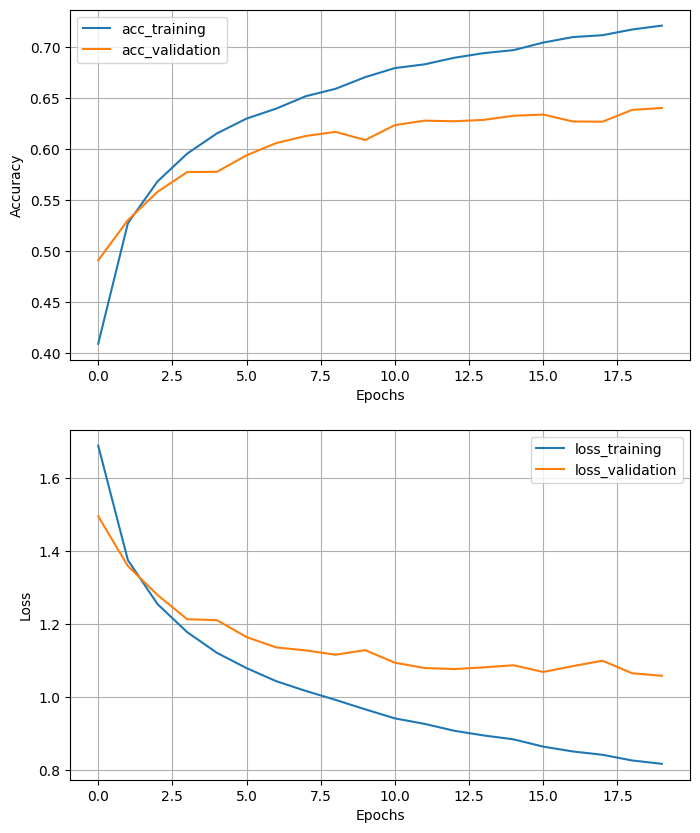

In [ ]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

Finally, we test the model:

In [ ]:
def test(model, dataloader_test=dataloader_test):
  model.eval()
  total_acc_test, total_count_test, n_batches_test, loss = 0, 0, 0, 0
  for idx, (img, label) in enumerate(dataloader_test):
      img, label = img.to(device), label.to(device)
      logits = model(img)
      loss += criterion(logits, label)
      total_acc_test += (logits.argmax(1) == label).sum().item()
      total_count_test += label.size(0)
      n_batches_test += 1
  accuracy_test = total_acc_test/total_count_test
  loss_test = loss/n_batches_test
  print(f"Test Loss: {loss_test:.8f}", end=' ---------- ')
  print(f"Test Accuracy: {100*accuracy_test:.4f}%")

In [ ]:
test(model)

Test Loss: 1.03888690 ---------- Test Accuracy: 64.5500%


Here we see that the test accuracy of our simple CNN is about 64%.

## Visualize filters
Let's now visualize the filters emerged in the first convolutional layer.

In [ ]:
layer_names = []
weights = {}
for name, param in model.named_parameters():
    if param.requires_grad:
        layer_names.append(name)
        weights.setdefault(name, param.data)

conv_weights = weights['conv_layers.0.weight']
print(f"{conv_weights.shape=} <=> [out_dim, inp_dim, kernel_size[0], kernel_size[1]]")

conv_weights.shape=torch.Size([32, 3, 3, 3]) <=> [out_dim, inp_dim, kernel_size[0], kernel_size[1]]


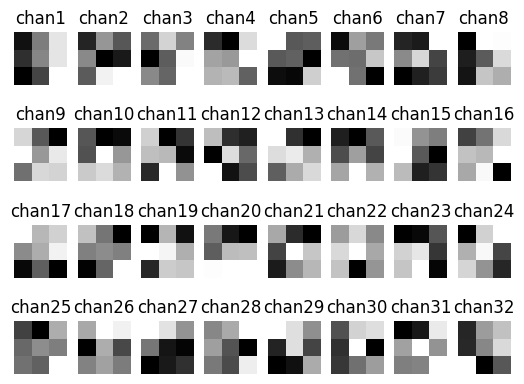

In [ ]:
conv_w0 = conv_weights[:, 0, :, :] # Pick one input dimension

# Rescale weights for visualization
conv_w0 -= torch.min(conv_w0)
conv_w0 /= torch.max(conv_w0)

for r in range(4):
    for c in range(8):
        n=r*8+c
        plt.subplot(4, 8, n+1)
        plt.imshow(conv_w0[n,:,:].cpu(), interpolation='none')
        plt.title(f'chan{n+1}')
        plt.axis('off')
        plt.gray()
plt.show()

They might be a bit hard to interpret, but it seems that the various filters have learned to detect various corners and edges.

## Parameters of a CNN [TO COMPLETE]

Explain in the cell below:

1. How are the number of parameters for Conv2D layers are determined? Perform the calculations to calculate the parameters of the Conv2D layer. 

`%STARTEXT`

Answer1 : The number of parameters in a given layer is the number of learnable elements in the filter of that layer. So for the conv2 layer the parameters of all the values in the filters. We can compute them by the following formula (plus 1 is for the bias term):
**(((width of filter* height of filter* number of the filters of the previous layer) + 1)*number of the filters of current layer)**
So for our conv2 number of parameters would be:
(((3* 3* 3)+1)*32) = 896






`%ENDTEXT`

# Exercise 3.2: Deep CNN


Let's consider a deeper model, more precisly in this exercise we consider a model composed of:
* One 2D convolutional layer with kernel size 3x3 and 32 output filters/features, that use ReLu activation function
* a Max Pooling layer (2D) of size 2x2 
* One 2D convolutional layer with kernel size 2x2 and 16 output filters/features, that use ReLu activation function
* a Max Pooling layer (2D) of size 2x2
* a Flatten layer
* a final Dense layer with 10 output neurons (one per class), and with the _softmax_ activation function


In [ ]:
conv_filters = [32, 16]
kernel_sizes = [[3, 3], [2, 2]]
max_pool_sizes = [[2, 2], [2, 2]]
act_fs = [F.relu, F.relu]

num_epochs = 20
lr = 1e-3
deep_model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                      act_fs, False).to(device)
summary(deep_model, input_size=(batch_size, 3, 32, 32)) # Here is a nice summary of our model!

Layer (type:depth-idx)                   Output Shape              Param #
My_Convolutional_Network                 [256, 10]                 --
├─ModuleList: 1-3                        --                        (recursive)
│    └─Conv2d: 2-1                       [256, 32, 32, 32]         896
├─ModuleList: 1-4                        --                        --
│    └─MaxPool2d: 2-2                    [256, 32, 16, 16]         --
├─ModuleList: 1-3                        --                        (recursive)
│    └─Conv2d: 2-3                       [256, 16, 16, 16]         2,064
├─ModuleList: 1-4                        --                        --
│    └─MaxPool2d: 2-4                    [256, 16, 8, 8]           --
├─Linear: 1-5                            [256, 10]                 10,250
Total params: 13,210
Trainable params: 13,210
Non-trainable params: 0
Total mult-adds (M): 372.77
Input size (MB): 3.15
Forward/backward pass size (MB): 75.52
Params size (MB): 0.05
Estimated Total S

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(deep_model.parameters(), lr=lr)

In [ ]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(deep_model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 35.26%, Loss: 1.83363247 ---------------- Val_Acc: 42.20%, Val_Loss: 1.62386382
epoch: 2 -> Accuracy: 47.25%, Loss: 1.49592304 ---------------- Val_Acc: 48.68%, Val_Loss: 1.44334924
epoch: 3 -> Accuracy: 52.09%, Loss: 1.36178172 ---------------- Val_Acc: 52.86%, Val_Loss: 1.35212076
epoch: 4 -> Accuracy: 54.84%, Loss: 1.28740597 ---------------- Val_Acc: 53.86%, Val_Loss: 1.29458439
epoch: 5 -> Accuracy: 56.71%, Loss: 1.23714793 ---------------- Val_Acc: 55.76%, Val_Loss: 1.26248467
epoch: 6 -> Accuracy: 57.91%, Loss: 1.20822716 ---------------- Val_Acc: 56.82%, Val_Loss: 1.23785579
epoch: 7 -> Accuracy: 58.97%, Loss: 1.17845309 ---------------- Val_Acc: 56.56%, Val_Loss: 1.22618270
epoch: 8 -> Accuracy: 59.72%, Loss: 1.15506935 ---------------- Val_Acc: 58.30%, Val_Loss: 1.18670309
epoch: 9 -> Accuracy: 60.92%, Loss: 1.12300968 ---------------- Val_Acc: 58.90%, Val_Loss: 1.17482734
epoch: 10 -> Accuracy: 61.17%, Loss: 1.11272717 ---------------- Val_Acc: 57.92%, 

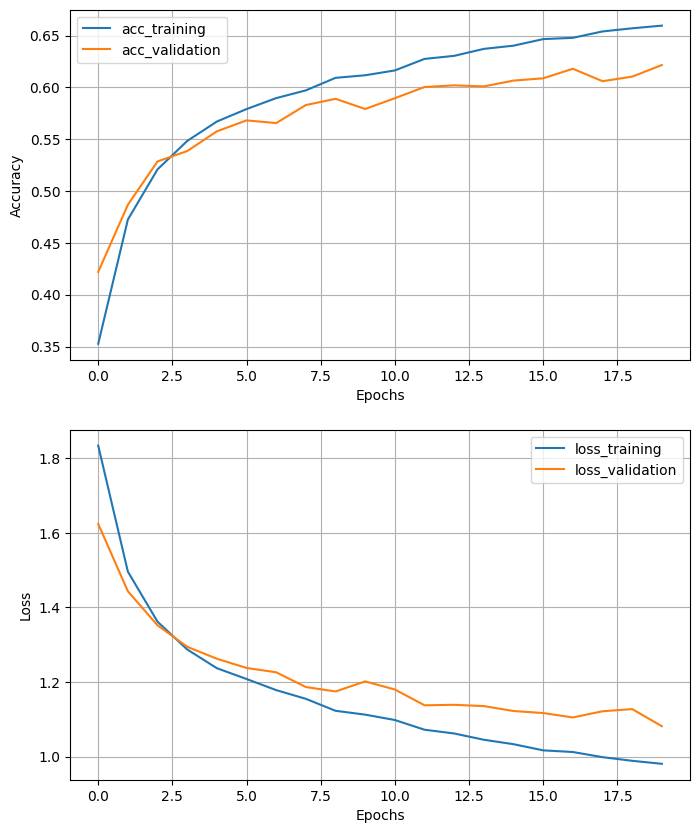

In [ ]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [ ]:
test(deep_model)

Test Loss: 1.04028332 ---------- Test Accuracy: 63.8500%


Whoa! By developing the deep CNN we dropped the accuracy fom ~64% to ~62%. It seems like we need to develop a better CNN model. 

# Exercise 3.3: A better CNN [TO COMPLETE]

Let's develop a network that performs better than the very simple one above. This exercise aims to explore how much the various hyper-parameters influence the classification capability of the model. 

**[TO COMPLETE]**: Your task is to modify some of the hyper-parameters of the previous exercise's network and compare the results. At least one of the models you try should have an improvement in the test set results (generalization) over the result of the model used in the previous exercise.
In the cell below report only the code of the **best model** that you can find. In addtion, print out its result on the test set, and plot the accuracy and the loss trends in the notebook you return.
Moreover, for each setup you test, analyze and discuss the obtained results briefly in the last cells at the bottom.

Hint: Each reparameterization should change a different aspect in the network, while the rest of the parameters would stay the same. 
Example parameters to try to change (we suggest to test at least one re-parametrization for each of these categories):

*    number of layers or neurons or filters dimension
*   activation functions
*   epochs
*   batch sizes
*   max-pooling on/off on certain layers, or pool size

`%STARTCODE`

In [ ]:
# MODEL; another layer added
# Test Loss: 0.83374232 ---------- Test Accuracy: 72.7800%

conv_filters = [32, 64, 128]
kernel_sizes = [[3, 3], [3, 3], [3, 3]]
max_pool_sizes = [[2, 2], [2, 2], [2, 2]]
act_fs = [F.relu, F.relu, F.relu]

num_epochs = 20
lr = 1e-3
model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                 act_fs, False).to(device)
summary(model, input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
My_Convolutional_Network                 [256, 10]                 --
├─ModuleList: 1-5                        --                        (recursive)
│    └─Conv2d: 2-1                       [256, 32, 32, 32]         896
├─ModuleList: 1-6                        --                        --
│    └─MaxPool2d: 2-2                    [256, 32, 16, 16]         --
├─ModuleList: 1-5                        --                        (recursive)
│    └─Conv2d: 2-3                       [256, 64, 16, 16]         18,496
├─ModuleList: 1-6                        --                        --
│    └─MaxPool2d: 2-4                    [256, 64, 8, 8]           --
├─ModuleList: 1-5                        --                        (recursive)
│    └─Conv2d: 2-5                       [256, 128, 8, 8]          73,856
├─ModuleList: 1-6                        --                        --
│    └─MaxPool2d: 2-6                    [256, 12

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 39.13%, Loss: 1.67887139 ---------------- Val_Acc: 49.00%, Val_Loss: 1.42837059
epoch: 2 -> Accuracy: 52.92%, Loss: 1.32063699 ---------------- Val_Acc: 55.68%, Val_Loss: 1.26270068
epoch: 3 -> Accuracy: 58.99%, Loss: 1.16187477 ---------------- Val_Acc: 59.22%, Val_Loss: 1.14520705
epoch: 4 -> Accuracy: 63.10%, Loss: 1.05441475 ---------------- Val_Acc: 62.58%, Val_Loss: 1.06866050
epoch: 5 -> Accuracy: 66.02%, Loss: 0.97981256 ---------------- Val_Acc: 64.16%, Val_Loss: 1.00906003
epoch: 6 -> Accuracy: 68.22%, Loss: 0.91629589 ---------------- Val_Acc: 66.62%, Val_Loss: 0.93702739
epoch: 7 -> Accuracy: 70.19%, Loss: 0.86308277 ---------------- Val_Acc: 67.64%, Val_Loss: 0.93588203
epoch: 8 -> Accuracy: 71.70%, Loss: 0.81964529 ---------------- Val_Acc: 67.94%, Val_Loss: 0.93447655
epoch: 9 -> Accuracy: 73.10%, Loss: 0.78094345 ---------------- Val_Acc: 69.10%, Val_Loss: 0.88788766
epoch: 10 -> Accuracy: 74.20%, Loss: 0.74973369 ---------------- Val_Acc: 69.06%, 

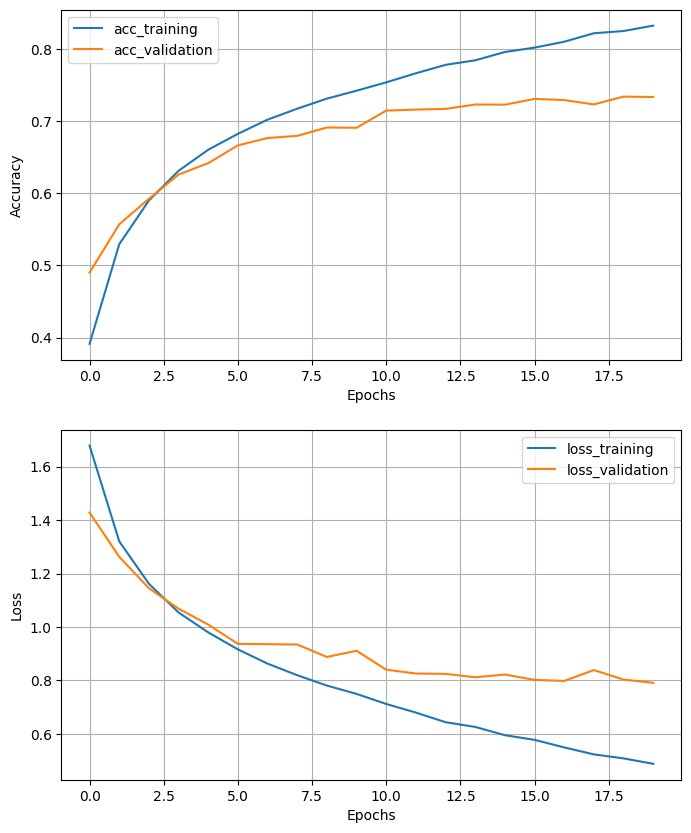

In [ ]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [ ]:
test(model)

Test Loss: 0.79575449 ---------- Test Accuracy: 73.9000%


`%ENDCODE`

# [TO COMPLETE] Discuss your results

In the discussion, you need to clearly motivate your choice of hyperparameters, what work and what did not work. 
You also need to plot all the results of experiments you have conducted. 

`%STARTEXT`

The best model that I found has three convolution layers, with activation relu and maxpooling. (Details above).

The achieved accuracy in the test set is... Test Loss: 0.83330202 ---------- Test Accuracy: 73.5200%

Discussion: I tried various things to improve the simple model. First I increased the number of filters in each layer, which seemed to improve the model. Then I tried to change the kernel size and colcluded that kernels smaller than [3, 3] don't give very prominent results. (Below I have the models I've experimented. In the comment section you can see the evaluation of that model on test data.) Therefore, I kept the kernel size [3,3] and added a third layer, and the model seemed to be improving. I tried to increased the number of filters in each layer and the model seemed to be overfitting. I even added a forth layer to see if there are any improvements but the results were not that different from a three layer CNN and the model was more prone to overfitting. I also tried changing the number of epochs but I didn't observe any significant improvement. 

Besides, I tested also other models: 
* 2 conv2d layers: [32,[3,3]],[64,2,2]] with maxpooling and relu activation, epochs=20, lr= 1e-3
* 3 conv2d layers: [64, 128, 256] kernel size:[3,3] with maxpooling and relu, ...
* 4 conv2d layers: [64, 64, 64, 64] kernel size [3,3]
maxpooling and relu activation, ...
* 4 conv2d layers: [64, 128, 128, 256] kernel size [3,3] maxpooling and relu activation, ...
* 3 conv2d layers: [32, 64, 128] kernel sizes: [4,4],[3,3],[2,2] maxpooling and relu activation, ...


Discussion:
**[TO COMPLETE]**

In [ ]:
# MODEL 1; increased num of channels to 64
# Test Loss: 0.87708074 ---------- Test Accuracy: 70.2400%

conv_filters = [32, 64]
kernel_sizes = [[3, 3], [3, 3]]
max_pool_sizes = [[2, 2], [2, 2]]
act_fs = [F.relu, F.relu]

num_epochs = 20
lr = 1e-3
model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                 act_fs, False).to(device)
summary(model, input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
My_Convolutional_Network                 [256, 10]                 --
├─ModuleList: 1-3                        --                        (recursive)
│    └─Conv2d: 2-1                       [256, 32, 32, 32]         896
├─ModuleList: 1-4                        --                        --
│    └─MaxPool2d: 2-2                    [256, 32, 16, 16]         --
├─ModuleList: 1-3                        --                        (recursive)
│    └─Conv2d: 2-3                       [256, 64, 16, 16]         18,496
├─ModuleList: 1-4                        --                        --
│    └─MaxPool2d: 2-4                    [256, 64, 8, 8]           --
├─Linear: 1-5                            [256, 10]                 40,970
Total params: 60,362
Trainable params: 60,362
Non-trainable params: 0
Total mult-adds (G): 1.46
Input size (MB): 3.15
Forward/backward pass size (MB): 100.68
Params size (MB): 0.24
Estimated Total S

In [ ]:
# MODEL 2 CHOSEN; another layer added
# Test Loss: 0.83374232 ---------- Test Accuracy: 72.7800%

conv_filters = [32, 64, 128]
kernel_sizes = [[3, 3], [3, 3], [3, 3]]
max_pool_sizes = [[2, 2], [2, 2], [2, 2]]
act_fs = [F.relu, F.relu, F.relu]

num_epochs = 20
lr = 1e-3
model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                 act_fs, False).to(device)
summary(model, input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
My_Convolutional_Network                 [256, 10]                 --
├─ModuleList: 1-5                        --                        (recursive)
│    └─Conv2d: 2-1                       [256, 32, 32, 32]         896
├─ModuleList: 1-6                        --                        --
│    └─MaxPool2d: 2-2                    [256, 32, 16, 16]         --
├─ModuleList: 1-5                        --                        (recursive)
│    └─Conv2d: 2-3                       [256, 64, 16, 16]         18,496
├─ModuleList: 1-6                        --                        --
│    └─MaxPool2d: 2-4                    [256, 64, 8, 8]           --
├─ModuleList: 1-5                        --                        (recursive)
│    └─Conv2d: 2-5                       [256, 128, 8, 8]          73,856
├─ModuleList: 1-6                        --                        --
│    └─MaxPool2d: 2-6                    [256, 12

In [ ]:
# MODEL 3; increased number of parameters, seems to be overfitting
# Test Loss: 1.08101356 ---------- Test Accuracy: 74.9100%

conv_filters = [64, 128, 256]
kernel_sizes = [[3, 3], [3, 3], [3, 3]]
max_pool_sizes = [[2, 2], [2, 2], [2, 2]]
act_fs = [F.relu, F.relu, F.relu]

num_epochs = 20
lr = 1e-3
model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                 act_fs, False).to(device)
summary(model, input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
My_Convolutional_Network                 [256, 10]                 --
├─ModuleList: 1-5                        --                        (recursive)
│    └─Conv2d: 2-1                       [256, 64, 32, 32]         1,792
├─ModuleList: 1-6                        --                        --
│    └─MaxPool2d: 2-2                    [256, 64, 16, 16]         --
├─ModuleList: 1-5                        --                        (recursive)
│    └─Conv2d: 2-3                       [256, 128, 16, 16]        73,856
├─ModuleList: 1-6                        --                        --
│    └─MaxPool2d: 2-4                    [256, 128, 8, 8]          --
├─ModuleList: 1-5                        --                        (recursive)
│    └─Conv2d: 2-5                       [256, 256, 8, 8]          295,168
├─ModuleList: 1-6                        --                        --
│    └─MaxPool2d: 2-6                    [256,

In [ ]:
# MODEL; forth layer added, seems more robust
# Test Loss: 0.82538766 ---------- Test Accuracy: 72.2400%

conv_filters = [64, 64, 64, 64]
kernel_sizes = [[3, 3], [3, 3], [3, 3], [3, 3]]
max_pool_sizes = [[2, 2], [2, 2], [2, 2], [2, 2]]
act_fs = [F.relu, F.relu, F.relu, F.relu]

num_epochs = 20
lr = 1e-3
model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                 act_fs, False).to(device)
summary(model, input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
My_Convolutional_Network                 [256, 10]                 --
├─ModuleList: 1-7                        --                        (recursive)
│    └─Conv2d: 2-1                       [256, 64, 32, 32]         1,792
├─ModuleList: 1-8                        --                        --
│    └─MaxPool2d: 2-2                    [256, 64, 16, 16]         --
├─ModuleList: 1-7                        --                        (recursive)
│    └─Conv2d: 2-3                       [256, 64, 16, 16]         36,928
├─ModuleList: 1-8                        --                        --
│    └─MaxPool2d: 2-4                    [256, 64, 8, 8]           --
├─ModuleList: 1-7                        --                        (recursive)
│    └─Conv2d: 2-5                       [256, 64, 8, 8]           36,928
├─ModuleList: 1-8                        --                        --
│    └─MaxPool2d: 2-6                    [256, 

In [ ]:
# MODEL; forth layer added, increased num of parameters; seems to be overfitting
# Test Loss: 1.29138172 ---------- Test Accuracy: 73.6200%

conv_filters = [64, 128, 128, 256]
kernel_sizes = [[3, 3], [3, 3], [3, 3], [3, 3]]
max_pool_sizes = [[2, 2], [2, 2], [2, 2], [2, 2]]
act_fs = [F.relu, F.relu, F.relu, F.relu]

num_epochs = 20
lr = 1e-3
model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                 act_fs, False).to(device)
summary(model, input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
My_Convolutional_Network                 [256, 10]                 --
├─ModuleList: 1-7                        --                        (recursive)
│    └─Conv2d: 2-1                       [256, 64, 32, 32]         1,792
├─ModuleList: 1-8                        --                        --
│    └─MaxPool2d: 2-2                    [256, 64, 16, 16]         --
├─ModuleList: 1-7                        --                        (recursive)
│    └─Conv2d: 2-3                       [256, 128, 16, 16]        73,856
├─ModuleList: 1-8                        --                        --
│    └─MaxPool2d: 2-4                    [256, 128, 8, 8]          --
├─ModuleList: 1-7                        --                        (recursive)
│    └─Conv2d: 2-5                       [256, 128, 8, 8]          147,584
├─ModuleList: 1-8                        --                        --
│    └─MaxPool2d: 2-6                    [256,

In [ ]:
# MODEL; forth layer added, decreased num of parameter, still seems to be overfitting
# Test Loss: 1.11625004 ---------- Test Accuracy: 73.9000%

conv_filters = [32, 64, 128, 256]
kernel_sizes = [[3, 3], [3, 3], [3, 3], [3, 3]]
max_pool_sizes = [[2, 2], [2, 2], [2, 2], [2, 2]]
act_fs = [F.relu, F.relu, F.relu, F.relu]

num_epochs = 20
lr = 1e-3
model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                 act_fs, False).to(device)
summary(model, input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
My_Convolutional_Network                 [256, 10]                 --
├─ModuleList: 1-7                        --                        (recursive)
│    └─Conv2d: 2-1                       [256, 32, 32, 32]         896
├─ModuleList: 1-8                        --                        --
│    └─MaxPool2d: 2-2                    [256, 32, 16, 16]         --
├─ModuleList: 1-7                        --                        (recursive)
│    └─Conv2d: 2-3                       [256, 64, 16, 16]         18,496
├─ModuleList: 1-8                        --                        --
│    └─MaxPool2d: 2-4                    [256, 64, 8, 8]           --
├─ModuleList: 1-7                        --                        (recursive)
│    └─Conv2d: 2-5                       [256, 128, 8, 8]          73,856
├─ModuleList: 1-8                        --                        --
│    └─MaxPool2d: 2-6                    [256, 12

In [ ]:
# MODEL; changed the kernel and pooling sizes, smaller sizes don't give good results
# Test Loss: 0.86643982 ---------- Test Accuracy: 70.5700%

conv_filters = [32, 64, 128]
kernel_sizes = [[4, 4], [3, 3], [2, 2]]
max_pool_sizes = [[2, 2], [2, 2], [2, 2]]
act_fs = [F.relu, F.relu, F.relu]

num_epochs = 20
lr = 1e-3
model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                 act_fs, False).to(device)
summary(model, input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
My_Convolutional_Network                 [256, 10]                 --
├─ModuleList: 1-5                        --                        (recursive)
│    └─Conv2d: 2-1                       [256, 32, 32, 32]         1,568
├─ModuleList: 1-6                        --                        --
│    └─MaxPool2d: 2-2                    [256, 32, 16, 16]         --
├─ModuleList: 1-5                        --                        (recursive)
│    └─Conv2d: 2-3                       [256, 64, 16, 16]         18,496
├─ModuleList: 1-6                        --                        --
│    └─MaxPool2d: 2-4                    [256, 64, 8, 8]           --
├─ModuleList: 1-5                        --                        (recursive)
│    └─Conv2d: 2-5                       [256, 128, 8, 8]          32,896
├─ModuleList: 1-6                        --                        --
│    └─MaxPool2d: 2-6                    [256, 

`%ENDTEXT`

# Transfer Learning with ResNet18 + ImageNet

Let's now experiment with transfer learning. We will now load the model structure and weights of a small [ResNet](https://en.wikipedia.org/wiki/Residual_neural_network) (which is still pretty big!), pretrained on the ImageNet dataset. We will then add a fully connected layer at the end of the network and fine-tune it on the CIFAR10 dataset. In this way, we can leverage the knowledge already present in the pre-trained weight and transfer it on our task!

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

In [ ]:
RESNET18 = resnet18(pretrained=True)
summary(RESNET18, input_size=(batch_size, 3, 32, 32))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [256, 1000]               --
├─Conv2d: 1-1                            [256, 64, 16, 16]         9,408
├─BatchNorm2d: 1-2                       [256, 64, 16, 16]         128
├─ReLU: 1-3                              [256, 64, 16, 16]         --
├─MaxPool2d: 1-4                         [256, 64, 8, 8]           --
├─Sequential: 1-5                        [256, 64, 8, 8]           --
│    └─BasicBlock: 2-1                   [256, 64, 8, 8]           --
│    │    └─Conv2d: 3-1                  [256, 64, 8, 8]           36,864
│    │    └─BatchNorm2d: 3-2             [256, 64, 8, 8]           128
│    │    └─ReLU: 3-3                    [256, 64, 8, 8]           --
│    │    └─Conv2d: 3-4                  [256, 64, 8, 8]           36,864
│    │    └─BatchNorm2d: 3-5             [256, 64, 8, 8]           128
│    │    └─ReLU: 3-6                    [256, 64, 8, 8]           --
│

The ResNet has a final fully connected layer that generates 1000 logits corresponding to the classes in the ImageNet dataset. We will re-define it and make it map the features learned in the previous layer to the 10 classes of the CIFAR10 datset. 

In [ ]:
linear_layer_input = RESNET18.fc.in_features
linear_layer_output = RESNET18.fc.out_features
print(f"Last layer: {linear_layer_input} -> {linear_layer_output}")

Last layer: 512 -> 1000


In [ ]:
# Replace  the last layer
RESNET18.fc = Linear(linear_layer_input, 10)

In [ ]:
linear_layer_input = RESNET18.fc.in_features
linear_layer_output = RESNET18.fc.out_features
print(f"Last layer: {linear_layer_input} -> {linear_layer_output}")

Last layer: 512 -> 10


Finally, we "freeze" the other weights in the network so that only the ones in the last layer are trainable.

In [ ]:
for name, param in RESNET18.named_parameters():
    if name == 'fc.weight' or name == 'fc.bias':
      param.requires_grad = True
    else:
      param.requires_grad = False

In [ ]:
RESNET18 = RESNET18.to(device) # Let's now load it to GPU

Let's consider a smaller subset of CIFAR10 in order to speed-up the fine-tuning process:

In [ ]:
train_idxs = list(range(0, len(train_data), 5))  # 45000/5=9000 Tr
val_idxs = list(range(1, len(val_data), 5))  # 5000/5=1000 Val
test_idxs = list(range(1, len(test_data), 5))  # 10000/5=2000 Ts

train_data_sub = torch.utils.data.Subset(train_data, train_idxs)
val_data_sub = torch.utils.data.Subset(val_data, val_idxs)
test_data_sub = torch.utils.data.Subset(test_data, test_idxs)

In order to apply custom preprocessing steps that are expected by the pretrained model, we will define a small wrapper around the CIFAR10 dataset.

In [ ]:
weights = ResNet18_Weights.DEFAULT
preprocess = weights.transforms()

class RESDatasetWrapper(Dataset):
  def __init__(self, dataset):
    self.dataset = dataset
  def __len__(self):
    return len(self.dataset)
  def __getitem__(self, idx):
    image, label = self.dataset[idx]
    image = preprocess(image)
    label = torch.tensor(label, dtype=torch.long)
    return image.to(device), label.to(device)

In [ ]:
RES_train_dataset = RESDatasetWrapper(train_data_sub)
RES_val_dataset = RESDatasetWrapper(val_data_sub)
RES_test_dataset = RESDatasetWrapper(test_data_sub)

batch_size=256

RES_dataloader_training = DataLoader(RES_train_dataset, batch_size=batch_size, shuffle=True)
RES_dataloader_validation = DataLoader(RES_val_dataset, batch_size=batch_size)
RES_dataloader_test = DataLoader(RES_test_dataset, batch_size=batch_size)

In [ ]:
num_epochs = 10
lr = 1e-3

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(RESNET18.parameters(), lr=lr)

In [ ]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(RESNET18, optimizer,
                                                           RES_dataloader_training, 
                                                           RES_dataloader_validation,
                                                           epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 36.87%, Loss: 1.85990274 ---------------- Val_Acc: 59.30%, Val_Loss: 1.41663516
epoch: 2 -> Accuracy: 64.31%, Loss: 1.21270108 ---------------- Val_Acc: 64.80%, Val_Loss: 1.10473239
epoch: 3 -> Accuracy: 71.02%, Loss: 0.98457497 ---------------- Val_Acc: 67.60%, Val_Loss: 0.97159302
epoch: 4 -> Accuracy: 73.48%, Loss: 0.88135689 ---------------- Val_Acc: 70.00%, Val_Loss: 0.89022624
epoch: 5 -> Accuracy: 74.47%, Loss: 0.81703258 ---------------- Val_Acc: 70.30%, Val_Loss: 0.84765762
epoch: 6 -> Accuracy: 75.54%, Loss: 0.77364337 ---------------- Val_Acc: 71.70%, Val_Loss: 0.81694341
epoch: 7 -> Accuracy: 76.37%, Loss: 0.73059452 ---------------- Val_Acc: 70.60%, Val_Loss: 0.79458767
epoch: 8 -> Accuracy: 76.78%, Loss: 0.71281070 ---------------- Val_Acc: 72.40%, Val_Loss: 0.78611708
epoch: 9 -> Accuracy: 77.87%, Loss: 0.68875104 ---------------- Val_Acc: 72.90%, Val_Loss: 0.76494896
epoch: 10 -> Accuracy: 78.22%, Loss: 0.67292523 ---------------- Val_Acc: 72.00%, 

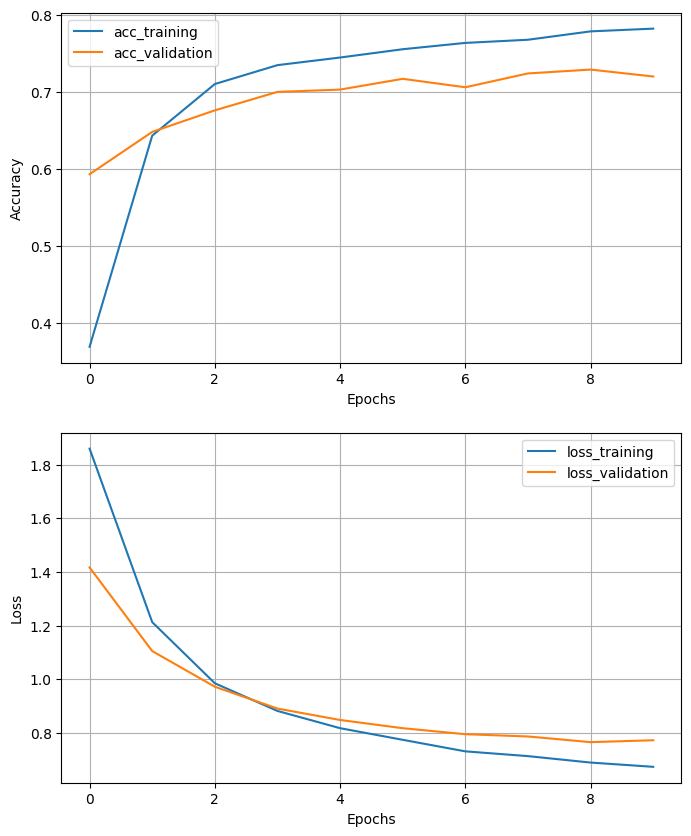

In [ ]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [ ]:
test(RESNET18, dataloader_test=RES_dataloader_test)

Test Loss: 0.77182066 ---------- Test Accuracy: 74.0500%


Notice how we got this result by leveraging a model freely available on the internet and trained on another dataset. That's the power of transfer learning! 